# Coursework 

**Initialize packages**

In [157]:
using JuMP, HiGHS, Plots, DataFrames, CSV, Statistics

**Reading Data**

In [158]:
flex_avail = DataFrame(CSV.File("input_files/Flexible_load_availability.csv"));

In [159]:
flex_load = DataFrame(CSV.File("input_files/Flexible_load_data.csv"));

In [160]:
fuels = DataFrame(CSV.File("input_files/Fuels_data.csv")); 

In [161]:
generators = DataFrame(CSV.File("input_files/Generators_data.csv"));

In [162]:
gen_var = DataFrame(CSV.File("input_files/Generators_variability.csv")) ;

In [163]:
load = DataFrame(CSV.File("input_files/Load_data.csv"));

In [164]:
network = DataFrame(CSV.File("input_files/Network.csv"));

In [165]:
# Extract row indices based on New_Build values
indices_new_build_1 = findall(generators.New_Build .== 1).+1;
#indices_new_build_minus1 = findall(generators.New_Build .== -1).+1;
#ndices_new_build_0 = findall(generators.New_Build .== 0).+1;

In [166]:
var_new = gen_var[:,indices_new_build_1];

### Problem formulation
The objective function will be:
$\begin{align}
\min &\sum_{g \in Gen} FixedCost_g \times CAP_g + \sum_{g\in Gen}\sum_{h \in H} VarCost_g \times GEN_{g,h} +\\[6pt]
&\quad\quad \sum_{h \in H} NSECost \times NSE_h &\\
\end{align}$

s.t. the constraints
$\begin{align}
&\text{Supply demand balance constraint:}&\\[6pt]
&\sum_{g \in NEW} CAP_{g,h,j} + \sum_{s \in STOR} (DISCHARGE_{s,h,j} -CHARGE_{s,h,j} ) + &\\
& NSE_{h,j} - Demand_{h,j} + FShift_{h,j} -PShift_{h,j} = \sum_{j \in J_i} FLOW_{ij} & \forall \quad i \in \mathcal{N}\\
\end{align}$


$\begin{align}
&\text{Thermal limit constraint:}&\\[6pt]
& FLOW_{ij} \leq MaxFlow_{ij} & \forall \quad i \in \mathcal{N}, \forall j \in J_i \\
&\text{Flow direction constraint:}&\\[6pt]
& FLOW_{ij} = - FLOW_{ji} & \forall \quad i, j \in \mathcal{N} \\
\end{align}
$

$\begin{align}
&\text{Capacity constraint for new generators:}&\\[6pt]
& 0 \leq  GEN_{g,h} \leq CAP_g \times CF_{g,h} & \forall \quad g \in NEW, h \in H\\[6pt]
&\text{Capacity constraint for nuclear:}&\\[6pt]
& GEN_{Nuclear,h} = CAP_{Nuclear} & \forall h \in H\\[6pt]
&\text{Capacity variable only for new build:}&\\[6pt]
& CAP_{g} \geq 0 & \forall \quad g \in NEW\\[6pt]
&\text{NSE constraint:}&\\[6pt]
& NSE_{h} \geq 0 & \forall \quad h \in H
\end{align}$

$\begin{align}
&\text{Charging and discharging constraint for storage:}&\\[6pt]
& 0 \leq CHARGE_{s,h} \leq CAP_s  & \forall \quad s \in STOR,  h \in H\\[6pt]
& 0 \leq DISCHARGE_{s,h} \leq CAP_s  & \forall \quad s \in STOR,  h \in H\\[6pt]
& 0 \leq SOC_{s,h} \leq SOC_{s}^{max}& \forall \quad s \in S, h \in H\\[6pt]
& SOC_{s,1} = SOC_{s,t_{end}} = 50\% *SOC_{s}^{max}& \forall \quad s \in S\\[6pt]
&\text{Efficiency of storage constraint:}&\\[6pt]
& SOC_{s,h}=SOC_{s,h-1} + \big(CHARGE_{s,h} * Eff_s - \frac{DISCHARGE_{s,h}}{Eff_s}\big)  & \forall \quad s \in S, h \in H \setminus {1} \\[6pt]
\end{align}$


**SETS**

**CASE 1: NO FLEXIBILITY**

**Sets**

In [167]:
# Storage
storage = generators[generators.Resource .== "battery", :];

In [168]:
gen = generators[generators.Resource .!= "battery", :];

In [169]:
# The set of hours in the demand DataFrame
H = load.Time_index; # same for every zone
H_2 = H[2:end];
# The set of generators from the generators DataFrame
generators = generators[generators.New_Build .== 1, :];

In [170]:
new_col_names = string.(generators.R_ID);  # Convert to String
rename!(var_new, new_col_names);


In [171]:
Id_storage=storage.R_ID;
Id_gen=gen.R_ID;
type_gen=gen.Resource;
N=[1,2,3,4,5,6]; #zones
L=[1,2,3,4,5,6,7,8,9,10];



In [172]:
# Define the Incident Matrix
A = [
    1   -1   0    0    0    0;
    1    0  -1    0    0    0;
    0    1  -1    0    0    0;
    0    1   0   -1    0    0;
    0    0   1   -1    0    0;
    0    0   0    1   -1    0;
    0    0   0    1    0   -1;
    1    0   0    0   -1    0;
    0    1   0    0   -1    0;
    0    0   1    0   -1    0
];

**Model**

In [173]:
NoFlex_Model = Model(HiGHS.Optimizer) # using the HiGHS open source solver

A JuMP Model
├ solver: HiGHS
├ objective_sense: FEASIBILITY_SENSE
├ num_variables: 0
├ num_constraints: 0
└ Names registered in the model: none

**Variables**

In [174]:
##TEST


@variables(NoFlex_Model, begin
    # Generating capacity (MW)
    CAP[g in Id_gen, z in N] >= 0
    # Storage capacity (MW)
    CAP_stor[s in Id_storage, z in N] >= 0
    
    # Generation in each hour (MWh)
    GEN[g in Id_gen, z in N, h in H] >= 0
    
    # Non-served energy in each hour (MWh) – currently uses zones 1:6
    NSE[h in H, z in N] >= 0
    
    # Flow
    FLOW[l in L, h in H]
    
    # Storage operations (charge/discharge in MW, SOC in MWh)
    0 <= DISCHARGE[s in Id_storage, z in N, h in H]# <= CAP_stor[s, z]
    0 <= CHARGE[s in Id_storage, z in N, h in H]    #<= CAP_stor[s, z]
    0 <= SOC[s in Id_storage, z in N, h in H]       #<= CAP_stor[s, z] * storage.Max_Duration[s]
    
end)





(2-dimensional DenseAxisArray{VariableRef,2,...} with index sets:
    Dimension 1, [1, 2, 3, 4, 5, 6, 7, 8, 9, 10  …  162, 163, 164, 165, 166, 167, 168, 169, 170, 171]
    Dimension 2, [1, 2, 3, 4, 5, 6]
And data, a 153×6 Matrix{VariableRef}:
 CAP[1,1]    CAP[1,2]    CAP[1,3]    CAP[1,4]    CAP[1,5]    CAP[1,6]
 CAP[2,1]    CAP[2,2]    CAP[2,3]    CAP[2,4]    CAP[2,5]    CAP[2,6]
 CAP[3,1]    CAP[3,2]    CAP[3,3]    CAP[3,4]    CAP[3,5]    CAP[3,6]
 CAP[4,1]    CAP[4,2]    CAP[4,3]    CAP[4,4]    CAP[4,5]    CAP[4,6]
 CAP[5,1]    CAP[5,2]    CAP[5,3]    CAP[5,4]    CAP[5,5]    CAP[5,6]
 CAP[6,1]    CAP[6,2]    CAP[6,3]    CAP[6,4]    CAP[6,5]    CAP[6,6]
 CAP[7,1]    CAP[7,2]    CAP[7,3]    CAP[7,4]    CAP[7,5]    CAP[7,6]
 CAP[8,1]    CAP[8,2]    CAP[8,3]    CAP[8,4]    CAP[8,5]    CAP[8,6]
 CAP[9,1]    CAP[9,2]    CAP[9,3]    CAP[9,4]    CAP[9,5]    CAP[9,6]
 CAP[10,1]   CAP[10,2]   CAP[10,3]   CAP[10,4]   CAP[10,5]   CAP[10,6]
 CAP[11,1]   CAP[11,2]   CAP[11,3]   CAP[11,4]   CAP[11,

In [175]:
@variables(NoFlex_Model, begin
        CAP[g in gen.R_ID, z in gen.Zone] >=0          # Generating capacity built (MW)
        CAP_stor[s in storage.R_ID, z in gen.Zone] >=0          # Generating capacity built (MW)
        GEN[g in gen.Resource, z in gen.Zone, h in H] >= 0 # Generation in each hour (MWh)
        NSE[h in H, z in 1:6] >= 0         # Non-served energy in each hour (MWh)
        FLOW[L,h in H] #flow
        0 <= DISCHARGE[s in storage.R_ID,z in storage.Zone ,h in H] <= CAP_stor[storage.R_ID.==s]           # Power discharge (MW)
        0 <= CHARGE[s in storage.R_ID,z in storage.Zone ,h in H] <= CAP_stor[storage.R_ID.==s]               # Power charge (MW)
        0 <= SOC[s in storage.R_ID,z in storage.Zone,h in H] <= CAP_stor[storage.R_ID.==s].*storage.Max_Duration[storage.R_ID.==s]  #Energy stoirage staeioif charge (MWh)
end)

LoadError: An object of name CAP is already attached to this model. If this
    is intended, consider using the anonymous construction syntax, for example,
    `x = @variable(model, [1:N], ...)` where the name of the object does
    not appear inside the macro.

    Alternatively, use `unregister(model, :CAP)` to first unregister
    the existing name from the model. Note that this will not delete the
    object; it will just remove the reference at `model[:CAP]`.


In [ ]:
@constraints(NoFlex_Model, begin
NuclearInflefibility[h in H, z in gen.Zone], GEN["Nuclear", h,z] == CAP[gen.Resource.=="Nuclear"]   #States inflexibility of nuclear plants

GEN[g in gen.R_ID, z in gen.Zone, h in H]<=CAP[g,z]*var_new[h,g]

 #Zone-1
 cBalance1[i=1,h in H], sum(GEN[g,h] for g in gen[gen.Zone .== i,:R_ID]) - sum(DEMAND[d,h] for d in load[load.Load_MW_z1]) +  sum((DISCHARGE[s,1,h]-CHARGE[s,1,h])for s in storage) + NSE[h,1]== sum(A[l,i]*FLOW[l,h] for l in L)
      
 #Zone-2
 cBalance2[i=2,h in H], sum(GEN[g,h] for g in gen[gen.Zone .== i,:R_ID]) - sum(DEMAND[d,h] for d in load[load.Load_MW_z2]) +  sum((DISCHARGE[s,2,h]-CHARGE[s,2,h])for s in storage) + NSE[h,2]== sum(A[l,i]*FLOW[l,h] for l in L)

 #Zone-3
 cBalance3[i=3,h in H], sum(GEN[g,h] for g in gen[gen.Zone .== i,:R_ID]) - sum(DEMAND[d,h] for d in load[load.Load_MW_z3]) +  sum((DISCHARGE[s,3,h]-CHARGE[s,3,h])for s in storage) + NSE[h,3]== sum(A[l,i]*FLOW[l,h] for l in L)

 #Zone-4
 cBalance4[i=4,h in H], sum(GEN[g,h] for g in gen[gen.Zone .== i,:R_ID]) - sum(DEMAND[d,h] for d in load[load.Load_MW_z4]) +  sum((DISCHARGE[s,4,h]-CHARGE[s,4,h])for s in storage) + NSE[h,4]== sum(A[l,i]*FLOW[l,h] for l in L)

 #Zone-5
 cBalance5[i=5,h in H], sum(GEN[g,h] for g in gen[gen.Zone .== i,:R_ID]) - sum(DEMAND[d,h] for d in load[load.Load_MW_z5]) +  sum((DISCHARGE[s,5,h]-CHARGE[s,5,h])for s in storage) + NSE[h,5]== sum(A[l,i]*FLOW[l,h] for l in L)

 #Zone-6 
 cBalance6[i=6,h in H], sum(GEN[g,h] for g in gen[gen.Zone .== i,:R_ID]) - sum(DEMAND[d,h] for d in load[load.Load_MW_z6]) +  sum((DISCHARGE[s,6,h]-CHARGE[s,6,h])for s in storage) + NSE[h,6]== sum(A[l,i]*FLOW[l,h] for l in L)
 #Thermal constraint
for l in 1:10
        FLOW[l,h in H] <= network[l,:Line_Max_Flow_MW]
# Flow constraints on each branch (reverse direction)
        FLOW[l,h in H] >= -network[l,:Line_Max_Flow_MW]
end



StateOfCharge[s in ,h in H_2],  SOC[s,h]== SOC[s,h-1] + storage[storage.R_ID.==s]
StateOfCharge[s in storage.R_ID, h in H_2],     SOC[s,h] == SOC[s,h-1] + storage[storage.R_ID.==s,:Charge_efficiency][1]*CHARGE[s,h] - DISCHARGE[s,h]/storage[storage.R_ID.==s,:Discharge_efficiency][1] # State of charge of storage units
StateOfcharge_ini[s in storage.R_ID],  SOC[s,1]==0.5*CAP_stor[storage.R_ID.==s].*storage.Max_Duration[storage.R_ID.==s] #States initial condition for SOC level (assumes half SOC)
StateOfcharge_end[s in storage.R_ID],  SOC[s,2688]==0.5*CAP_stor[storage.R_ID.==s].*storage.Max_Duration[storage.R_ID.==s] #States final condition for SOC level (assumes half SOC)





)

**Objective function**

In [ ]:
@objective(NoFlex_Model,Min,
(sum(gen[gen.R_ID==g, Inv_cost_per_MWyr]+sum(gen[gen.R_ID==g, Fixed_OM_cost_per_MWyr])))*CAP[g] +
(sum(storage[storage.R_ID==s, Inv_cost_per_MWyr]+sum(storage[storage.R_ID==s, Fixed_OM_cost_per_MWyr])))*CAP_stor[s] +

(sum(gen[gen.R_ID==g, Var_OM_cost_per_MWh])+sum(gen[gen.R_ID==g,Heat_rate_MMBTU_per_MWh]*gen[gen.R_ID==g,Cost_per_MMBtu]))*GEN[g]*load[load.Repre]  
)


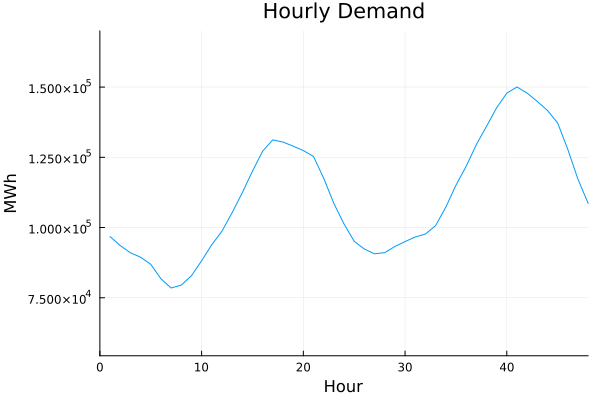

In [ ]:
plot(load.Load_MW_z1+load.Load_MW_z2+load.Load_MW_z3+load.Load_MW_z4+load.Load_MW_z5+load.Load_MW_z6, xlims=(0,48) ,label="")
title!("Hourly Demand")
xaxis!("Hour")
yaxis!("MWh")

#print(load.Load_MW_z1)